# NN rruff DataBase For Powder Difraction X-Ray

### Creating the tensor DataSet and Labels

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
# Finding the Data Directory
data_dir = '/content/drive/My Drive/ML_rruff'
os.chdir(data_dir)

# List the contents of the directory
print(os.listdir())

print("------------")

os.chdir('XY_Processed')
dirs = os.listdir()
print(dirs)

['XY_Processed', 'EX1', 'Selected', 'DataSet.ipynb', 'NN_Pro.ipynb', 'NN.ipynb', 'Tensors', 'NN_Pro2.ipynb', 'NN_Pro3.ipynb']
------------
['Diamond__R050207-9__Powder__Xray_Data_XY_Processed__7229.txt', 'Diaoyudaoite__R050182-9__Powder__Xray_Data_XY_Processed__6935.txt', 'Diaphorite__R060173-9__Powder__Xray_Data_XY_Processed__2352.txt', 'Diaspore__R060546-1__Powder__Xray_Data_XY_Processed__3677.txt', 'Diaspore__R060287-1__Powder__Xray_Data_XY_Processed__2783.txt', 'Dickite__R060298-1__Powder__Xray_Data_XY_Processed__2779.txt', 'Dickite__R090054-1__Powder__Xray_Data_XY_Processed__10128.txt', 'Dietrichite__R070381-1__Powder__Xray_Data_XY_Processed__8417.txt', 'Digenite__R060840-1__Powder__Xray_Data_XY_Processed__6871.txt', 'Diopside__R040009-1__Powder__Xray_Data_XY_Processed__2567.txt', 'Diopside__R040097-1__Powder__Xray_Data_XY_Processed__3420.txt', 'Diopside__R050406-1__Powder__Xray_Data_XY_Processed__5733.txt', 'Diopside__R050496-1__Powder__Xray_Data_XY_Processed__1811.txt', 'Diopsid

In [4]:
# Get Data Function

def get_data(file_path):
    # Read the data from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the data points
    data = []
    metadata = []
    for line in lines:
        if line.startswith('##'):
            metadata.append(line.strip())
        else:
            try:
                x, y = map(float, line.strip().split(','))
                data.append((x, y))
            except ValueError:
                #print(f"Warning: Skipping invalid data: '{line.strip()}'")
                pass

    if not data:
        print("Error: No valid data points found in the file.")
        return


    #print(x_values)

    # Separate x and y values
    x_values, y_values = zip(*data)
    return x_values, y_values

x_values, y = get_data(dirs[0])
print(len(x_values))



8501


In [5]:
# Creating more Examples for eatch Sample by adding noise and X-shift

def create_noise(file_path, n=5, intensity_noise=0.04, peak_shift=1, peak_threshold=0.5):
    x_values, y_values = get_data(file_path)
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Identify peaks
    peaks, _ = find_peaks(y_values, height=peak_threshold * np.max(y_values), distance=1)

    noisy_data = []

    for _ in range(n):
        # Create peak shifts
        shifts = np.random.uniform(-peak_shift, peak_shift, size=len(peaks))
        shift_array = np.zeros_like(x_values)
        shift_array[peaks] = shifts

        # Smooth out shifts for neighboring points
        kernel = np.array([0.5, 1, 0.5])
        smoothed_shifts = np.convolve(shift_array, kernel, mode='same') / np.sum(kernel)

        noisy_x = x_values + smoothed_shifts

        # Add intensity noise
        noise = np.random.uniform(-intensity_noise * np.max(y_values),
                                  intensity_noise * np.max(y_values),
                                  size=len(y_values))
        noisy_y = np.maximum(0, y_values + noise)

        # Sort the data points based on x values to maintain order
        sorted_indices = np.argsort(noisy_x)
        noisy_x = noisy_x[sorted_indices]
        noisy_y = noisy_y[sorted_indices]

        noisy_data.append((noisy_x, noisy_y))

    return noisy_data



In [6]:
# Creating the DataPoints and Getting all Files from / to the Tensor

def Create_DataPoint(file_path, n):
    x_values, y_values = get_data(file_path)

    if len(x_values) != 8501:
        return None, None  # Return None if the file doesn't have 8501 data points

    # Extract the molecule name from the filename
    filename = os.path.basename(file_path)
    label = filename.split('__')[0]  # Get the part before the first '__'

    # Generate noisy data
    noisy_data = create_noise(file_path, n)

    # Combine original and noisy data
    labels = [label]*(n+1)
    all_y = [np.array(y_values)]
    for _, noisy_y in noisy_data:
        all_y.append(np.array(noisy_y))

    # Convert to tensor
    y_tensor = torch.from_numpy(np.array(all_y)).float()

    return y_tensor, labels


def process_all_files_in_directory(n=5):
    data_tensor = None
    all_labels = []

    # Get the current working directory
    directory_path = os.getcwd()

    # Get all files with .txt extension in the current directory
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]

    for file_name in txt_files:
        file_path = os.path.join(directory_path, file_name)
        y_tensor, labels = Create_DataPoint(file_path, n)

        if y_tensor is not None:
            # Add data to the main tensor
            if data_tensor is None:
                data_tensor = y_tensor
            else:
                data_tensor = torch.cat((data_tensor, y_tensor), dim=0)

            all_labels.extend(labels)

    return data_tensor, all_labels

# Usage
data_tensor, labels = process_all_files_in_directory(n=5)



In [7]:
print(f"Final data tensor shape: {data_tensor.shape}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {len(set(labels))}")
output_p = (list(set(labels)))
print(output_p)

Final data tensor shape: torch.Size([7692, 8501])
Number of labels: 7692
Unique labels: 756
['Leucosphenite', 'Nordstrandite', 'Chamosite', 'Hedenbergite', 'Alunogen', 'Beraunite', 'Lawsonite', 'Dravite', 'HydroxyapophylliteK', 'Gillespite', 'Elpidite', 'Woodhouseite', 'ArrojaditeKNa', 'Ferropargasite', 'Natroalunite', 'Stibnite', 'Ammonioalunite', 'RinkiteCe', 'Wadeite', 'Laueite', 'Wollastonite', 'Miserite', 'Tunellite', 'Dioptase', 'Bottinoite', 'Cordierite', 'Fluororichterite', 'Caledonite', 'Chrysoberyl', 'Ferrowyllieite', 'Inesite', 'Fluorbuergerite', 'Cookeite', 'Rosasite', 'Clinozoisite', 'Edoylerite', 'Chlorartinite', 'FerrieriteMg', 'Sussexite', 'Cornetite', 'Osumilite', 'GmeliniteNa', 'Livingstonite', 'Colemanite', 'Phlogopite', 'AncyliteCe', 'Claudetite', 'GadoliniteY', 'Pseudomalachite', 'Hydroxylclinohumite', 'Scorodite', 'Wiluite', 'Siegenite', 'Corundum', 'Bellingerite', 'Kapustinite', 'Perroudite', 'Lollingite', 'TantaliteFe', 'Pyromorphite', 'Trona', 'Tarbuttite', 'Ba

In [8]:
!ls
#os.chdir('..')

Acanthite__R080016-1__Powder__Xray_Data_XY_Processed__9701.txt
Actinolite__R040063-1__Powder__Xray_Data_XY_Processed__3298.txt
Actinolite__R040064-1__Powder__Xray_Data_XY_Processed__3302.txt
Actinolite__R050025-1__Powder__Xray_Data_XY_Processed__527.txt
Actinolite__R050336-1__Powder__Xray_Data_XY_Processed__5327.txt
Actinolite__R060041-1__Powder__Xray_Data_XY_Processed__2599.txt
Actinolite__R060045-1__Powder__Xray_Data_XY_Processed__2138.txt
Adamite__R040130-1__Powder__Xray_Data_XY_Processed__3772.txt
Adamite__R050020-1__Powder__Xray_Data_XY_Processed__667.txt
Adamite__R060593-1__Powder__Xray_Data_XY_Processed__5516.txt
Aegirine__R040054-1__Powder__Xray_Data_XY_Processed__3209.txt
Aegirine__R050074-1__Powder__Xray_Data_XY_Processed__532.txt
AeschyniteY__R060312-1__Powder__Xray_Data_XY_Processed__2738.txt
AeschyniteY__R080045-1__Powder__Xray_Data_XY_Processed__9435.txt
Afghanite__R060422-1__Powder__Xray_Data_XY_Processed__3590.txt
AgarditeY__R060711-1__Powder__Xray_Data_XY_Processed__11

In [13]:
!ls

data_tensor.pt	labels.pt  Parameters


-------------
Diamond


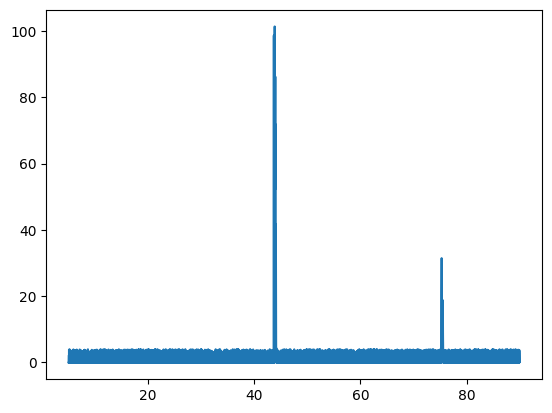

In [10]:
# Plotting an Example

plt.plot(x_values, data_tensor[1])
print("-------------")
print(labels[1])

#--------------------------------------------
# Creating the NN

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:

import torch
import torch.nn.functional as F

def prepare_labels_for_cross_entropy(labels, all_labels):
    # Create a dictionary mapping each unique label to a unique integer
    label_to_index = {label: idx for idx, label in enumerate(set(all_labels))}

    # Convert labels to their corresponding integers
    label_indices = [label_to_index[label] for label in labels]

    # Convert to tensor
    label_indices_tensor = torch.tensor(label_indices, dtype=torch.long)

    # Create one-hot encoded tensor
    num_classes = len(label_to_index)
    one_hot_labels = F.one_hot(label_indices_tensor, num_classes=num_classes)

    return one_hot_labels, label_indices_tensor, label_to_index

# Usage
#Alredy run...
#data_tensor, labels = process_all_files_in_directory(n=5)
unique_labels = list(set(labels))
one_hot_labels, label_indices, label_to_index = prepare_labels_for_cross_entropy(labels, unique_labels)

print(f"One-hot labels shape: {one_hot_labels.shape}")
print(f"Label indices shape: {label_indices.shape}")
print(f"Unique Labels: {len(label_to_index)}")




One-hot labels shape: torch.Size([7692, 756])
Label indices shape: torch.Size([7692])
Unique Labels: 756


In [13]:
print(one_hot_labels[0])
print(label_indices.shape)
print(label_to_index)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
# This is not working... some labels are getting out of order... and the test batch is all failing.
"""
# Assuming data_tensor shape is [7692, 8501] and label_indices is a tensor or list of length 7692

# Step 1: Create a permutation
num_samples = data_tensor.shape[0]
perm = torch.randperm(num_samples)

# Step 2: Shuffle both data_tensor and label_indices
shuffled_data_tensor = data_tensor[perm]
if isinstance(label_indices, torch.Tensor):
    shuffled_label_indices = label_indices[perm]
else:
    shuffled_label_indices = [label_indices[i] for i in perm.tolist()]

# Step 3: Keep only the first 100 cases for kept_data and its labels
num_keep = 100
kept_data = shuffled_data_tensor[:num_keep]
kept_labels = shuffled_label_indices[:num_keep]

# Step 4: Remove the first 100 cases from data_tensor and label_indices
data_tensor = shuffled_data_tensor[num_keep:]
label_indices = shuffled_label_indices[num_keep:]

# Print shapes to verify
print("Shape of data_tensor (shuffled - 100 cases):", data_tensor.shape)
print("Length of label_indices (shuffled - 100 cases):", len(label_indices))
print("Shape of kept_data (100 cases):", kept_data.shape)
print("Length of kept_labels (100 cases):", len(kept_labels))

"""
print("Great!!")

Great!!


In [35]:
class NN(torch.nn.Module):
    def __init__(self, label_to_index):
        super().__init__()
        self.g = torch.Generator().manual_seed(2147483647)

        self.W1 = torch.nn.Parameter(torch.randn((8501, 4000), generator=self.g))
        self.b1 = torch.nn.Parameter(torch.randn(4000, generator=self.g))
        self.W2 = torch.nn.Parameter(torch.randn((4000, 1500), generator=self.g))
        self.b2 = torch.nn.Parameter(torch.randn(1500, generator=self.g))
        self.W3 = torch.nn.Parameter(torch.randn((1500, len(label_to_index)), generator=self.g))
        self.b3 = torch.nn.Parameter(torch.randn(len(label_to_index), generator=self.g))

        print(f"The NN has: {sum(p.numel() for p in self.parameters())} parameters")

    def forward(self, data_tensor, label_indices):
        h = torch.tanh(data_tensor @ self.W1 + self.b1)
        h2 = torch.tanh(h @ self.W2 + self.b2)
        logits = h2 @ self.W3 + self.b3
        probabilities = F.softmax(logits, dim=1)

        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(logits, label_indices)

        return loss

    def __call__(self, data_tensor):
        h = torch.tanh(data_tensor @ self.W1 + self.b1)
        h2 = torch.tanh(h @ self.W2 + self.b2)
        logits = h2 @ self.W3 + self.b3
        probabilities = F.softmax(logits, dim=0)

        return probabilities

nn_model = NN(label_to_index)
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.1)

nn_model = nn_model.to('cuda')
data_tensor = data_tensor.to('cuda')
label_indices = label_indices.to('cuda')


The NN has: 41144256 parameters


In [16]:
loss = nn_model.forward(data_tensor, label_indices)
print(f"The initial loss is: {loss}")
print(f"We have {len(data_tensor)} Examples.")
print(f"We have {len(label_to_index)} Molecules.")

The initial loss is: 120.09580993652344
We have 7592 Examples.
We have 756 Molecules.


In [46]:
while True:
    optimizer.zero_grad()
    loss = nn_model.forward(data_tensor, label_indices)
    loss.backward()

    print(f"The loss is: {loss}")
    optimizer.step()


    if loss.item() < 1e-2:
        print("Reached Stop Point!!")
        break



Streaming output truncated to the last 5000 lines.
The loss is: 0.017580216750502586
The loss is: 0.01757802441716194
The loss is: 0.017575813457369804
The loss is: 0.01757359504699707
The loss is: 0.01757139526307583
The loss is: 0.01756918802857399
The loss is: 0.017566969618201256
The loss is: 0.017564771696925163
The loss is: 0.017562562599778175
The loss is: 0.017560362815856934
The loss is: 0.01755814626812935
The loss is: 0.017555948346853256
The loss is: 0.017553742974996567
The loss is: 0.01755153201520443
The loss is: 0.017549319192767143
The loss is: 0.0175471231341362
The loss is: 0.017544914036989212
The loss is: 0.017542704939842224
The loss is: 0.01754051074385643
The loss is: 0.01753830537199974
The loss is: 0.017536096274852753
The loss is: 0.01753389462828636
The loss is: 0.017531707882881165
The loss is: 0.017529496923089027
The loss is: 0.017527299001812935
The loss is: 0.017525093629956245
The loss is: 0.017522884532809258
The loss is: 0.017520682886242867
The loss

In [25]:
# Use this to get to the dir
#os.chdir('Test1')
!ls

In [37]:
# Saving the Model...
torch.save(nn_model.state_dict(), '10e2_nst.pth')

NN()

In [42]:
nn_model.load_state_dict(torch.load('10e2_nst.pth'))
nn_model.eval()  # Set the model to evaluation mode

NN()

Expected label:  Szaibelyite
Predicted label: Tincalconite
Probability: 1.0000


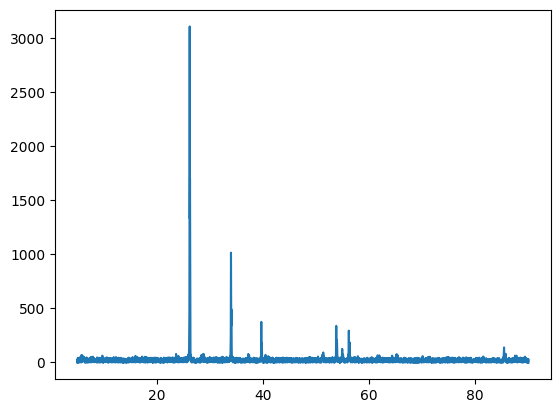

(1.0, False)

In [44]:

index_to_label = {v: k for k, v in label_to_index.items()}  # Reverse the dictionary
def test_example(data_tensor, i, p_info=True):

  probabilities = nn_model(data_tensor[i])

  max_prob_index = torch.argmax(probabilities).item()

  predicted_label = index_to_label[max_prob_index]
  if p_info == True:
    #print(data_tensor[i])
    print(f"Expected label:  {index_to_label[label_indices[i].item()]}")
    print(f"Predicted label: {predicted_label}")
    print(f"Probability: {probabilities[max_prob_index].item():.4f}")

    plt.plot(x_values, data_tensor[10].cpu())
    plt.show()


  return probabilities[max_prob_index].item(), index_to_label[label_indices[i].item()] == predicted_label

test_example(data_tensor, 6084)

In [45]:
print(f"Size of Test Batch: {len(data_tensor)}")
probs = []
for i in range(len(data_tensor)):
  result, correct = test_example(data_tensor, i, False)
  if result >= 0.6:
    if correct == False:
      print(i)
    probs.append(result)

print(sum(probs) / len(probs))

Size of Test Batch: 7592
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
195
196
197
198
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
225
226
227
228
229
230
232
233
234
235
236
237
238
239
240
241
243
244
245
246
247
248
249
250
251
253
254
255
256
257
258
259
260
262
263
264
265
266
267
269
270
271
272
273
274
276
277
278
279
280
281
282


KeyboardInterrupt: 